In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis,get_time_plate_info_long_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave,plot_single_plate
import matplotlib.patches as mpatches
import statsmodels.api as sm
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
import scipy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.io as sio
import matplotlib as mpl
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.legend_handler import HandlerTuple
import seaborn as sns
from scipy.integrate import odeint
import scienceplots
import logging
logging.getLogger().setLevel(logging.WARNING)
%matplotlib widget
%store -r path_figure

plt.style.use('presentation.mplstyle')
# plt.style.use('science')
plates = ['94_20201123']
plate_select = [94]
# plt.rcParams['font.family'] = 'Helvetica'  # Set font family

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
width = 1.6
height = 1

In [3]:
def select_movement(plate_id, time_hypha_info, min_num_occ=1):
    time_hypha_plate = time_hypha_info.loc[time_hypha_info["unique_id"] == plate_id]
    select = time_hypha_plate
    max_speeds = select.groupby("end").max()["speed"]
    correct_tracks = max_speeds.loc[max_speeds <= 450]
    select = select.loc[select["end"].isin(correct_tracks.index)]
    select = select.loc[select["distance_final_pos"] >= 1500]
    select = select.loc[select["speed"].between(50, 400)]
    select = select.loc[select["in_ROI"] == "True"]
    num_occ = select.groupby("end").count()["speed"]
    correct_tracks = num_occ.loc[num_occ >= min_num_occ]
    select = select.loc[select["end"].isin(correct_tracks.index)]
    select_movements = select
    return select_movements


def get_average_time_data(plate_id, time_hypha_info, min_num_occ=1):
    select_movements = select_movement(plate_id, time_hypha_info, min_num_occ)
    group = select_movements.groupby(["time_since_begin_h"])["speed"]
    data = group.median()
    dy = group.std() / np.sqrt(group.count())

    return (data, dy, select_movements)

In [4]:
all_analysis_folders = get_analysis_folders()
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]

folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders)


In [5]:
plate_id = '94_20201123'
plate_id_int = int(plate_id)
data,dy,select_movements = get_average_time_data(plate_id_int,time_hypha_info,2)
hyphae_hull = get_hyphae_hull(plate_id,analysis_folders)
timesteps = []
hypha_hulls = []
for timestep,line in enumerate(hyphae_hull):
    timesteps += [timestep for hyph in line]
    hypha_hulls += [hyph for hyph in line]
data_front = pd.DataFrame((np.array((timesteps,hypha_hulls))).transpose(),columns=('timestep','label'))
data_front['timestep_label'] = data_front['timestep'].astype(str)+data_front['label'].astype(str)
select_movements['group_time'] = select_movements['timestep']//10
select_movements['timestep_label'] = select_movements['timestep'].astype(str)+select_movements['end'].astype(str)

select_movements['is_hull_pusher'] = select_movements["timestep_label"].isin(data_front['timestep_label'])
select = select_movements.loc[select_movements['timestep']<100]

Text(0, 0.5, '$cos(\\theta-\\theta_0)$')

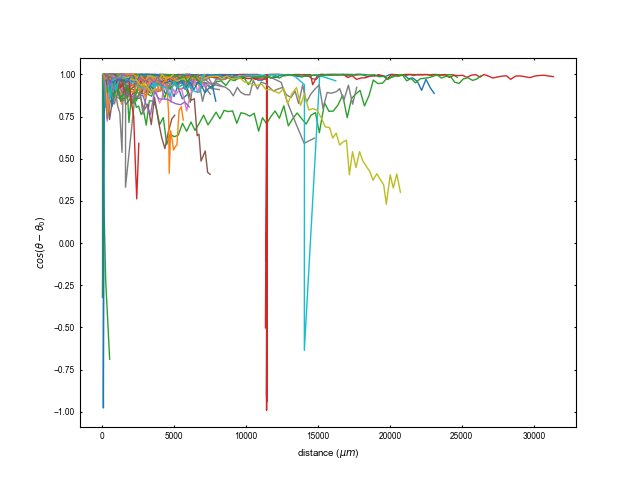

In [6]:
fig,ax = plt.subplots()
select_hyphae = select_movements.loc[select_movements['timestep']<100]

select_hyphae = select_movements.loc[select_movements['speed']>200].copy()
vecs_lists = []    
# for j,hyph in enumerate([0,  118, 58, 1]):
for j,hyph in enumerate(select_hyphae['end'].unique()):
    select_hypha = select_movements.loc[select_movements['end']==hyph]
#     select_hypha = select_hypha.loc[select_hypha['timestep']<100]
    
#     select_hypha = select_hypha.loc[select_hypha['speed']>200].copy()
    

    select_hypha = select_hypha.sort_values('timestep')
    vecx,vecy = select_hypha['pos_x'].diff(1),select_hypha['pos_y'].diff(1)
    vecx_norm = vecx/(vecx**2+vecy**2)**(1/2)
    vecy_norm = vecy/(vecx**2+vecy**2)**(1/2)
    persistence = vecx_norm.iloc[1]*vecx_norm+vecy_norm.iloc[1]*vecy_norm
    dists = np.sqrt((select_hypha['pos_x']-select_hypha['pos_x'].iloc[0])**2+(select_hypha['pos_y']-select_hypha['pos_y'].iloc[0])**2)*1.725
    vecs_lists.append((dists.values,vecx_norm.iloc[1:].values,vecy_norm.iloc[1:].values))
    ax.plot(dists,persistence)
ax.set_xlabel('distance ($\mu m$)')
ax.set_ylabel(r'$cos(\theta-\theta_0)$')

In [9]:
def exp_func(x, a):
    return np.exp(-x / a)

In [13]:
len(vecs_lists)

118

2023-07-15 17:16:50,219-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


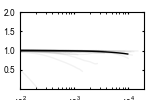

In [12]:
fig,ax = plt.subplots(figsize=(width,height))
# fig,ax = plt.subplots()

correlation_length = []
for k in range(len(vecs_lists)):
    dist = vecs_lists[k][0][1:]
    vecx = vecs_lists[k][1]
    vecy = vecs_lists[k][2]
    if len(vecx)>4:
        # Generate new regularly spaced x
        new_dist = np.linspace(start=dist.min(), stop=dist.max(), num=100)  # for instance, 100 points

        # Interpolate y values at new x
        new_vecx = np.cos(np.interp(new_dist, dist, np.arccos(vecx)))

        # Interpolate y values at new x
        new_vecy = np.sin(np.interp(new_dist, dist, np.arcsin(vecy)))

        correlation_func = np.zeros(len(new_vecx))

        # Compute the correlation function
        for i in range(len(new_vecx)):
            for j in range(i, len(new_vecx)):
                # Compute the cosine of the angle between the tangents
                cos_theta = new_vecx[i]*new_vecx[j]+new_vecy[i]*new_vecy[j]
                # Add to the correlation function
                correlation_func[j-i] += cos_theta

        # Average the correlation function
        correlation_func /= np.arange(len(new_vecx), 0, -1)
        popt, pcov = curve_fit(exp_func,new_dist[:len(new_vecx)//2]-new_dist[0], correlation_func[:len(new_vecx)//2],p0=[5000])
        correlation_length.append(popt[0])
        ax.plot(new_dist[:len(new_vecx)//2]-new_dist[0],correlation_func[:len(new_vecx)//2],color="grey",alpha = 0.1)
        xs = new_dist[:len(new_vecx)//2]-new_dist[0]
        # ax.plot(xs,np.exp(-xs/popt[0]))        
        # break
ax.set_xscale("log")
# ax.set_yscale("log")

xs = np.linspace(1e1,1e4,100)
ax.set_xlim(1e2,2e4)
ax.set_ylim(1e-4,2)

ax.plot(xs,np.exp(-xs/np.median(correlation_length)),color="black",linewidth=1)
ax.set_xlabel('$\Delta L(\mu m)$')
ax.set_ylabel('$\\langle \\cos(\Delta \\theta) \\rangle$')
plt.savefig(os.path.join(path_figure,'FigureS5B.pdf'), transparent=True, bbox_inches='tight')


In [205]:
np.median(correlation_length)

104417.39625478433

In [14]:
rh_angle = np.load('rh_angle.npy')
bas_angle = np.load('bas_angle.npy')

In [16]:
len(rh_angle),len(bas_angle)

(71, 881)

In [196]:
np.mean(np.abs(rh_angle)),np.mean(np.abs(bas_angle))

(73.71652101040532, 79.94013131052722)

In [198]:
np.std(np.abs(rh_angle))/np.sqrt(len(rh_angle))

4.8610857461753385

2023-07-13 21:58:14,805-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


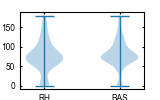

In [129]:
fig,ax = plt.subplots(figsize=(width,height))

ax.violinplot([np.abs(rh_angle),np.abs(bas_angle)])
ax.set_xticks([1, 2])
ax.set_xticklabels(['RH', 'BAS'])
ax.set_ylabel('branching angle (°)')
plt.savefig(os.path.join(path_figure,'FigureS5A.pdf'), transparent=True, bbox_inches='tight')
